#### Задание 
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import pandas as pd
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import re
import html
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping 

Using TensorFlow backend.


In [3]:
from gensim.models.word2vec import Word2Vec

In [4]:
stopwords=set(stopwords.words('russian'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

#### Гиперпараметры

In [5]:
max_words = 20000
max_len = 200
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [6]:
history = {}

#### Подготовка датасета

In [7]:
data = pd.read_excel("отзывы за лето.xls")
data.head(20)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
5,5,Всё удобно норм 👍👍👍,2017-08-14
6,5,Очень удобное приложение.,2017-08-14
7,5,Все устраивает,2017-08-14
8,5,У меня работает все четко. В отличии от банком...,2017-08-14
9,5,Очень все хорошо👍,2017-08-14


In [8]:
emoticon_dict = {
":)": "веселый",
":‑)": "веселый",
":-]": "веселый",
":-3": "веселый",
":->": "веселый",
"8-)": "веселый",
":-}": "веселый",
":o)": "веселый",
":c)": "веселый",
":^)": "веселый",
"=]": "веселый",
"=)": "веселый",
"<3": "веселый",
":-(": "грустный",
":(": "грустный",
":c": "грустный",
":<": "грустный",
":[": "грустный",
">:[": "грустный",
":{": "грустный",
">:(": "грустный",
":-c": "грустный",
":-< ": "грустный",
":-[": "грустный",
":-||": "грустный"
}

In [9]:
def  replace_words_in_dictonary(text, dictionary_words):     
    return ' '.join(dictionary_words.get(word, word) for word in text.split())

### Заменим эмотиконы (пример: ":)" = "happy") на пробелы, используя emoticon_dict. 
### Для этого воспользуемся функцией, используемой в предыдущем пункте.
def replace_emoticon(text):
    global emoticon_dict
    return replace_words_in_dictonary(str(text), emoticon_dict)

def replace_special_symbol(text):
    return  html.unescape(text)

def preprocess_text(text):
    global stopwords, exclude, morpher
    
    text = str(text)
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = replace_emoticon(text)
    text = replace_special_symbol(text)
    text = "".join(c for c in text if c not in exclude)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'[0-9]+', ' ', text)
    text = re.sub('\n', ' ', text)
    text = [morpher.parse(word)[0].normal_form for word in text.split() if word not in stopwords]
    text = " ".join(text)
    text = re.sub("не\s", "не", text)
    return text

In [10]:
data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3] #удаляем строки
data['target'] = (data['Rating'] > 3).astype(int)
data.head(20)

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложениеиз минус хотеть слиш...,1
2,5,Отлично все,2017-08-14,отлично,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать работа антивирус далёкий никуда...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,1
5,5,Всё удобно норм 👍👍👍,2017-08-14,весь удобно норма,1
6,5,Очень удобное приложение.,2017-08-14,очень удобный приложение,1
7,5,Все устраивает,2017-08-14,устраивать,1
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,работать чётко отличие банкомат который вечно ...,1
9,5,Очень все хорошо👍,2017-08-14,очень,1


In [11]:
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [12]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [13]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [14]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [15]:
x_train_matrix = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_train], dtype=np.int32)
x_val_matrix = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_val], dtype=np.int32)

In [16]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

#### Структура сети

In [17]:
def get_model(metric, weights=None):
    global max_len, max_words
    model = Sequential()
    if weights is None:
        print('Not use Embedding weights')
        model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    else:
        print('Use Embedding weights')
        model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len, weights=[weights]))
    model.add(Conv1D(32, 3))
    model.add(Activation("relu"))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metric])
    return model

In [31]:
metric = keras.metrics.AUC()
metric.name='auc'
model = get_model(metric)

Not use Embedding weights


#### Обучение

In [32]:
early_stopping=EarlyStopping(monitor='val_loss')  


history['baseline'] = model.fit(x_train_matrix, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Train on 14218 samples, validate on 1580 samples
Epoch 1/20
14218/14218 [==============================] - 6s 442us/step - loss: 0.5477 - auc: 0.8545 - val_loss: 0.4141 - val_auc: 0.9557
Epoch 2/20
14218/14218 [==============================] - 6s 417us/step - loss: 0.3952 - auc: 0.8997 - val_loss: 0.3130 - val_auc: 0.9607
Epoch 3/20
14218/14218 [==============================] - 23s 2ms/step - loss: 0.2620 - auc: 0.9639 - val_loss: 0.2089 - val_auc: 0.9743
Epoch 4/20
14218/14218 [==============================] - 10s 726us/step - loss: 0.1797 - auc: 0.9812 - val_loss: 0.1979 - val_auc: 0.9768
Epoch 5/20
14218/14218 [==============================] - 7s 510us/step - loss: 0.1421 - auc: 0.9879 - val_loss: 0.2014 - val_auc: 0.9773


In [33]:
score = model.evaluate(x_val_matrix, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test loss:', score[0])
print('Test AUC:', score[1])

3950/3950 [==============================] - 0s 78us/step


Test loss: 0.19126621500600743
Test AUC: 0.9779981970787048


#### Подготовка эмбеддинга

In [34]:
sentence_train = [[sentence] for sentence in X_train]

In [45]:
modelW2V = Word2Vec(sentences=sentence_train, size=max_words)

In [46]:
embedding_matrix = np.zeros((max_words, 128))

In [47]:
result = []
for word in vocabulary:
    if word in modelW2V.wv:
        padding = [0] * max(1, (128-len(modelW2V.wv[word])))
        embedding_matrix[vocabulary[word]] = padding+modelW2V.wv[word][-128:]      

#### Обучение модели

In [51]:
metric = keras.metrics.AUC()
metric.name='auc'
model = get_model(metric, embedding_matrix)

Use Embedding weights


In [52]:
early_stopping=EarlyStopping(monitor='val_loss')  


history['use_embedding'] = model.fit(x_train_matrix, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Train on 14218 samples, validate on 1580 samples
Epoch 1/20
14218/14218 [==============================] - 6s 445us/step - loss: 0.5909 - auc: 0.8503 - val_loss: 0.4310 - val_auc: 0.9556
Epoch 2/20
14218/14218 [==============================] - 6s 415us/step - loss: 0.3755 - auc: 0.9143 - val_loss: 0.2821 - val_auc: 0.9661
Epoch 3/20
14218/14218 [==============================] - 11s 806us/step - loss: 0.2421 - auc: 0.9696 - val_loss: 0.2132 - val_auc: 0.9737
Epoch 4/20
14218/14218 [==============================] - 9s 639us/step - loss: 0.1719 - auc: 0.9835 - val_loss: 0.1993 - val_auc: 0.9764
Epoch 5/20
14218/14218 [==============================] - 8s 550us/step - loss: 0.1342 - auc: 0.9893 - val_loss: 0.2090 - val_auc: 0.9762


In [53]:
score = model.evaluate(x_val_matrix, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test loss:', score[0])
print('Test AUC:', score[1])

3950/3950 [==============================] - 0s 75us/step


Test loss: 0.19819096974934203
Test AUC: 0.9779508709907532


In [56]:
def plot_history(history):
    fig = plt.figure()
    fig.set_size_inches(15, 15)

    ax_1 = fig.add_subplot(2, 2, 1)
    ax_2 = fig.add_subplot(2, 2, 2)
    ax_3 = fig.add_subplot(2, 2, 3)
    ax_4 = fig.add_subplot(2, 2, 4)


    for key in history.keys():
        ax_1.plot(history[key].history['auc'], label=key)
        ax_2.plot(history[key].history['val_auc'], label=key)
        ax_3.plot(history[key].history['loss'], label=key)
        ax_4.plot(history[key].history['val_loss'], label=key)

    ax_1.set(title = 'Model AUC on train data', label='AUC', xlabel='Epoch')
    ax_1.legend(loc='lower right')
    ax_2.set(title = 'Model AUC on test data', label='AUC', xlabel='Epoch')
    ax_2.legend(loc='lower right')
    ax_3.set(title = 'Model loss on train data', label='loss', xlabel='Epoch')
    ax_3.legend(loc='upper right')
    ax_4.set(title = 'Model loss on test data', label='loss', xlabel='Epoch')
    ax_4.legend(loc='upper right')

    plt.show()

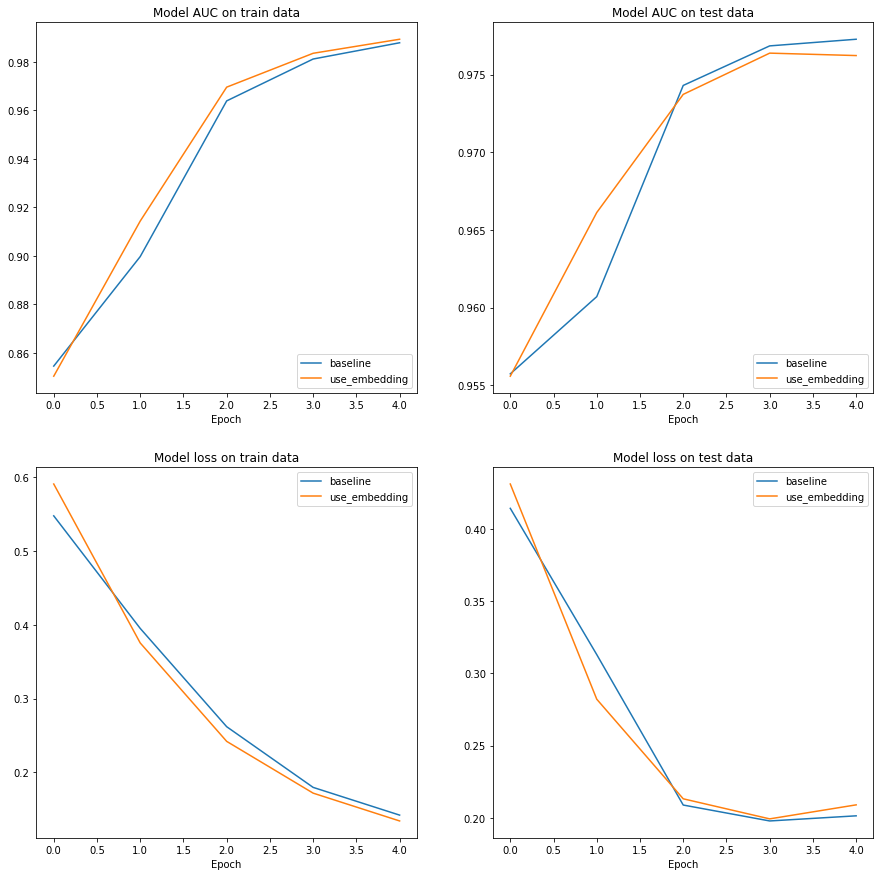

In [57]:
plot_history(history)

##### Вывод:
Использование эмбединга позволило модели на раннем этапе быстрее прийти к нужной точности. Но на скорость обучение в целом это не повлияло.